In [1]:
from LSTMCell import LSTM
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


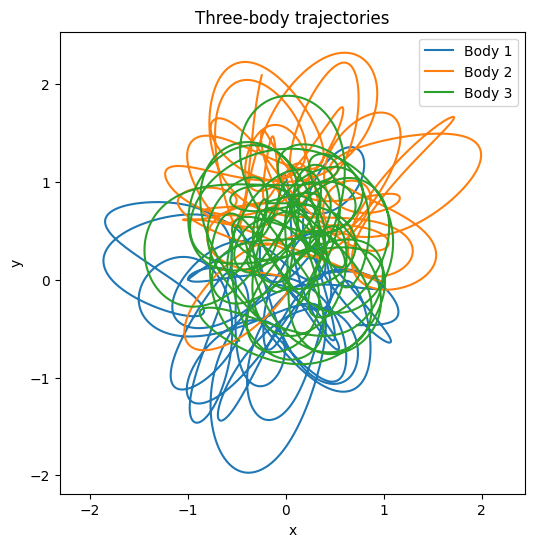

(3, 100000)


In [2]:
from data_creation import get_trajectories
%load_ext autoreload
%autoreload 2

sol = get_trajectories()

x,y,vx,vy,t = sol

print((x.shape))

In [3]:
import numpy as np


# Applied sigmoid but does not seem to do much
# We can first try without sigmoid


# custom function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# # test
x_sig = sigmoid(x)  
y_sig = sigmoid(y)
vx_sig = sigmoid(vx)
vy_sig = sigmoid(vy)


print(min(vx_sig[0]))
print(min(vy_sig[0]))



0.00023284527253112896
1.7000081657711662e-07


In [4]:
import numpy as np
import pandas as pd

data = np.vstack((x, y, vx, vy)).T

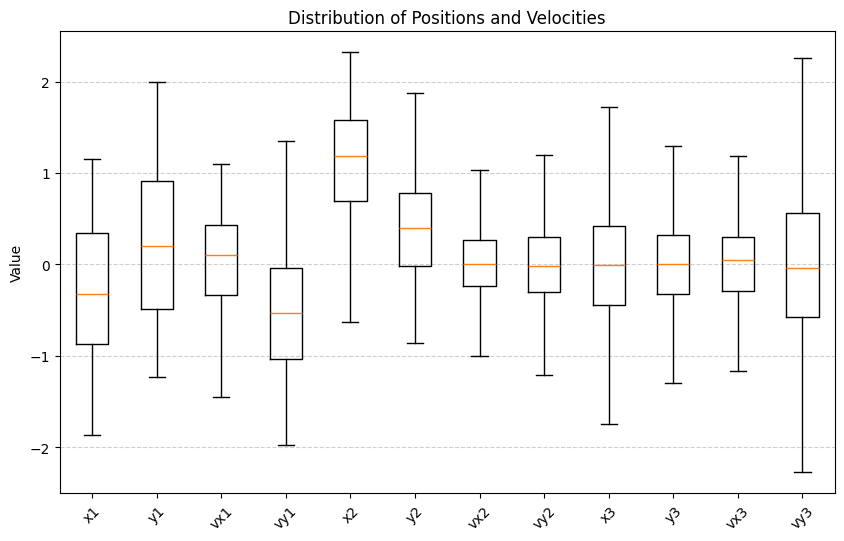

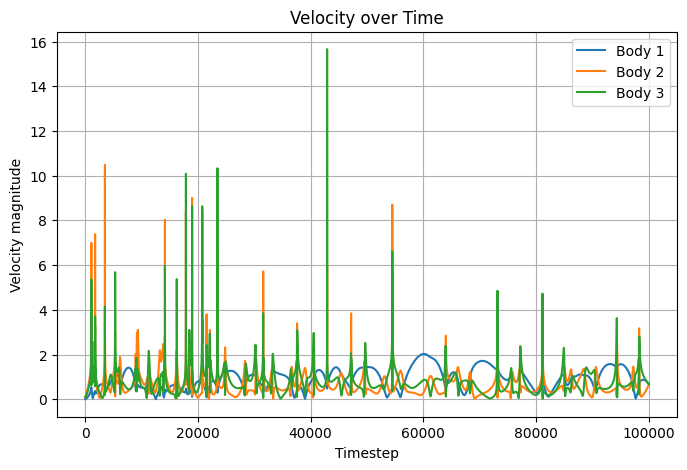

In [5]:
# data visualizations
from data_creation import plot_trajectories, plot_boxplots, plot_velocity_magnitude

plot_boxplots(data)
plot_velocity_magnitude(data)
# plot_trajectories(data)

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [7]:


# prev = np.roll(data, shift=1, axis=0)  # previous row values
# prev[0] = np.nan   # first row has no previous row
# print(prev.shape)

# lagged = np.hstack([data, prev])

print(data.shape)

lag = 10  # number of lagged time steps to as labels
# # Create lagged features
X = data[:-lag]
y = data[lag:]





print(X.shape, y.shape)

# # Split the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = RobustScaler()

# Fit on training data and transform
X_train = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test = scaler.transform(X_test)

seq_len = 10
X_train = np.array([X_train[i:i+seq_len] for i in range(len(X_train)-seq_len)])
X_test = np.array([X_test[i:i+seq_len] for i in range(len(X_test)-seq_len)])

print(X.shape, y.shape)
# # # Reshape the input data to 3D for LSTM
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))



(100000, 12)
(99990, 12) (99990, 12)
(99990, 12) (99990, 12)


Fold 1
Epoch [1/20], Train Loss: 0.4711, Val Loss: 0.5277
Epoch [2/20], Train Loss: 0.4615, Val Loss: 0.5216
Epoch [3/20], Train Loss: 0.4496, Val Loss: 0.5150
Epoch [4/20], Train Loss: 0.4312, Val Loss: 0.5068
Epoch [5/20], Train Loss: 0.4031, Val Loss: 0.4971
Epoch [6/20], Train Loss: 0.3762, Val Loss: 0.4830
Epoch [7/20], Train Loss: 0.3435, Val Loss: 0.4645
Epoch [8/20], Train Loss: 0.3041, Val Loss: 0.4420
Epoch [9/20], Train Loss: 0.2711, Val Loss: 0.4209
Epoch [10/20], Train Loss: 0.2415, Val Loss: 0.4017
Epoch [11/20], Train Loss: 0.2150, Val Loss: 0.3849
Epoch [12/20], Train Loss: 0.1938, Val Loss: 0.3710
Epoch [13/20], Train Loss: 0.1768, Val Loss: 0.3590
Epoch [14/20], Train Loss: 0.1624, Val Loss: 0.3482
Epoch [15/20], Train Loss: 0.1498, Val Loss: 0.3378
Epoch [16/20], Train Loss: 0.1381, Val Loss: 0.3275
Epoch [17/20], Train Loss: 0.1270, Val Loss: 0.3172
Epoch [18/20], Train Loss: 0.1164, Val Loss: 0.3068
Epoch [19/20], Train Loss: 0.1065, Val Loss: 0.2966
Epoch [20/20],

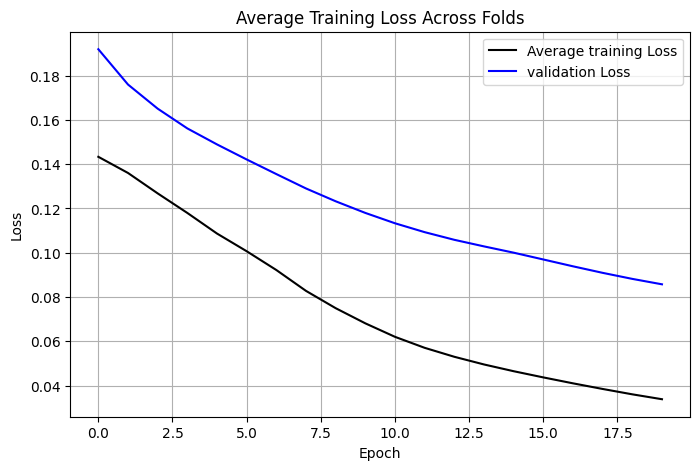

In [ ]:
from LSTMCell import LSTM
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

input_window_size = 12
hidden_size = 32
num_layers = 2

model = LSTM(input_window_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses, val_loss = model.training_loop_cv(
    num_epochs = 20, 
    criterion = criterion,
    optimizer = optimizer,
    trainX = X_train,
    trainY = y_train
)

losses_array = np.array(losses)        # shape: (num_folds, num_epochs)
avg_loss = np.mean(losses_array, axis=0)

losses_array = np.array(val_loss)        # shape: (num_folds, num_epochs)
avg_val_loss = np.mean(losses_array, axis=0)

plt.figure(figsize=(8, 5))
plt.plot(avg_loss, color='black', label='Average training Loss')
plt.plot(avg_val_loss, color='blue', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss Across Folds')
plt.grid(True)
plt.legend()
plt.show()

Generate time series from 1 input and plot both in one plot

### Save model

In [12]:
import time

timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"models/model_{timestamp}.pt"

torch.save(model, filename)
print(f"Model saved to {filename}")

Model saved to models/model_20251016-132705.pt


### Load model

In [13]:
import os
model_path = ""

if os.path.exists(model_path):
    print("Loading saved model...")
    model = torch.load(model)

torch.Size([20, 12]) <class 'torch.Tensor'>
torch.Size([10, 12]) <class 'torch.Tensor'>


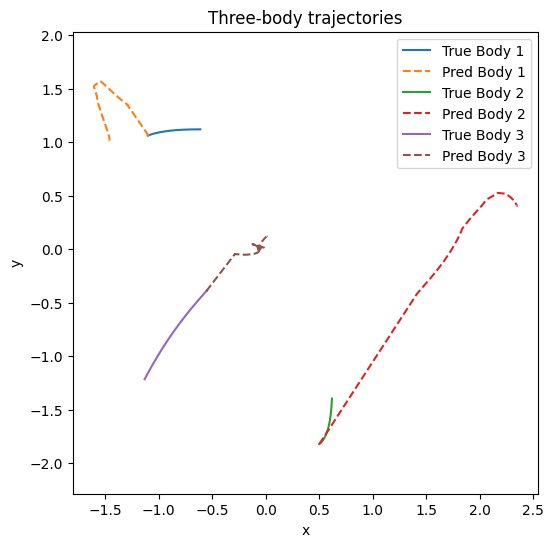

In [18]:
from data_creation import plot_trajectories
steps = 1000

sliding_window = 10
generated = X_test[:20]
generated = generated[:, 0, :]

output = model.generate_timeseries(X_test[0], steps=steps, generated=generated)

# remove middle dimension
X_test_selected = X_test[:, 0, :]

plot_trajectories(X_test_selected[0:steps], output)

### Grid search

In [15]:
from itertools import product
import torch
import os

# define the grid search parameters
param_grid = {'neurons': [2, 4, 8, 16, 32, 64, 128],
              'optimizer': ['SGD', 'RMSprop', 'Adam'],
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'window_size': [5, 10, 15, 20],
              'hidden_size': [32, 64, 128],
              }


# generate combinations
keys = param_grid.keys()
combinations = [dict(zip(keys, values)) for values in product(*param_grid.values())]
print(f"Total combinations to try: {len(combinations)}")
print(f"If training takes half an hour per combination, this will take {len(combinations)*0.5:.2f} hours, which is {len(combinations)*0.5/24:.2f} days.")

best_val_loss = float('inf')
best_params = None
best_model_state = None

for combo in combinations:
    print(f"Training with combo: {combo}")

    model = LSTM(input_window_size=combo['window_size'],
                 hidden_size=combo['hidden_size'],
                 num_layers=combo['num_layers'])
    
    if combo['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=combo['learning_rate'])
    elif combo['optimizer'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=combo['learning_rate'])
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=combo['learning_rate'])
    
    criterion = nn.MSELoss()

    losses, val_loss = model.training_loop_cv(
        num_epochs=10,
        criterion=criterion,
        optimizer=optimizer,
        trainX=X_train,
        trainY=y_train
    )

    final_val_loss = val_loss[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = combo
        best_model_state = model.state_dict()

print(f"Best combo: {best_params} with val loss: {best_val_loss:.4f}")
torch.save(best_model_state, "best_lstm_model.pt")
print("Best model saved to best_lstm_model.pt")

Total combinations to try: 1008
If training takes half an hour per combination, this will take 504.00 hours, which is 21.00 days.
Training with combo: {'neurons': 2, 'optimizer': 'SGD', 'learning_rate': 0.1, 'window_size': 5, 'hidden_size': 32}


KeyError: 'num_layers'